<a href="https://colab.research.google.com/github/YachaySCG/summer_school_2021/blob/master/template_tensorflow_sc_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Template

This is a project template for the challenge SC 2021

## Setup

In [ ]:
!pip -q install gdown

In [ ]:
import os
import torch
import numpy as np

# import needed libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import datetime
import csv
import pandas as pd

from PIL import Image

In [ ]:
CONNECT_GDRIVE = False

if CONNECT_GDRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive')
    if not os.path.exists("/content/gdrive/MyDrive/summer_school_2021"):
        os.path.makedirs("/content/gdrive/MyDrive/summer_school_2021")
    
    %cd /content/gdrive/MyDrive/summer_school_2021

In [ ]:
# Create folders and set cuda available
use_cuda = torch.cuda.is_available()

RESULT_DIR = './stuff/results/'
CHECKPOINTS_DIR = 'stuff/checkpoints/'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

if not os.path.isdir(CHECKPOINTS_DIR):
      os.mkdir(CHECKPOINTS_DIR)

---
# Data

## Source dataset

We will train the model using a modief version of Intel Classification Image dataset from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification), but with small tweaks we can get any other data we are interested in. The dataset is composed of image of 6 classes: `buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `AUGMENTATION` is `True`, data augmentation will be applied during training.

In [ ]:
#@title Download and uncompress the dataset

if not os.path.exists("stuff/data"):
    os.makedirs("stuff/data")

!gdown https://drive.google.com/uc?id=1pFWcrh9Qdn8irqognubPTjfaY1uDecFM
!unzip -qq dataset_sc_2021.zip
!mv test stuff/data/
!mv val stuff/data/
!mv train stuff/data/

Downloading...
From: https://drive.google.com/uc?id=1pFWcrh9Qdn8irqognubPTjfaY1uDecFM
To: /content/dataset_sc_2021.zip
116MB [00:00, 162MB/s] 


Prepare de Data

In [ ]:
IMG_SIZE = (150,150)

print('==> Preparing data..')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "stuff/data/train",
  seed=123,
  shuffle = False,
  image_size=IMG_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "stuff/data/val",
  seed=123,
  shuffle = False,
  image_size=IMG_SIZE)

==> Preparing data..
Found 9300 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


 Check the classes

In [ ]:
classes_names = train_ds.class_names
print(classes_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


# Displaying Data

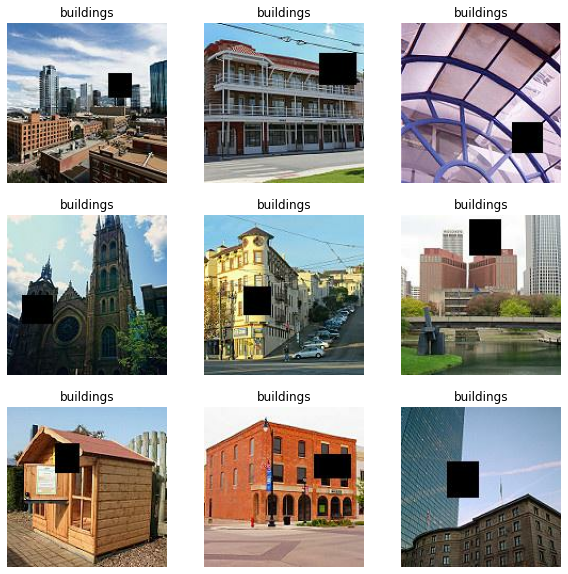

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #print(images[i].shape, np.amax(images[i].numpy()))
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes_names[labels[i]])
    plt.axis("off")

## Normalization and augmentation


For more information about data augmentation, see:

https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(*IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Normalization(mean = mean, variance=std)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
AUGMENTATION = False  # True/False if you want use torchvision augmentations

def prepare(ds, batch_size = None, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  
  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  if batch_size is not None:
    ds = ds.batch(BATCH_SIZE)

    
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
train_ds = prepare(train_ds, batch_size= BATCH_SIZE, shuffle = True, augment = AUGMENTATION) 
val_ds = prepare(val_ds, batch_size= BATCH_SIZE, shuffle = False, augment = AUGMENTATION) 

# Define a model


In [ ]:
# TODO: Define a tensorflow model

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    # TODO: Define the initialization step  
    ...

  def call(self, inputs):
    # TODO: define the forward pass
    return ..

model = MyModel()

## Training the model

In [ ]:
# TODO: Define the main functions for training and the main loop

### Plotting results

In [ ]:
#@title Util Functions

def plot_results(results, name):
  """
    results: pandas DataFrame with the following fields

        - epoch : number of epoch
        - train acc : value of the train accuracy at each epoch 
        - test acc : value of the test accuracy at each epoch 
        - train loss : value of the train loss at each epoch 
        - test loss : value of the test loss at each epoch 

    name: name to save the image result
  """
  train_accuracy = results['train acc'].values
  test_accuracy = results['test acc'].values

  train_loss = results['train loss'].values
  test_loss = results['test loss'].values

  figureName = name +"_results" # change figure name

  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)
  ax1.plot(results['epoch'].values, train_accuracy, label='train', color='r', marker='s', lw=3)
  ax1.plot(results['epoch'].values, test_accuracy, label='test', color='b', marker='o', lw=3)
  ax1.legend()
  ax1.set_ylim([0,100])
  ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
  ax2.plot(results['epoch'].values, train_loss, label='train', color='r', marker='s', lw=3)
  ax2.plot(results['epoch'].values, test_loss, label='test', color='b', marker='o', lw=3)
  ax2.legend()
  ax2.set(xlabel="Epochs", ylabel="Loss")
  fig.savefig(os.path.join(RESULT_DIR,f'{figureName}.png'))
  plt.show()


In [ ]:
!ls $RESULT_DIR

log_2021_09_06-17:33:42.csv  log_2021_09_06-18:46:44.csv
log_2021_09_06-17:33:54.csv  log_2021_09_06-18:48:41.csv
log_2021_09_06-18:43:25.csv


In [ ]:
# the plot_results function expects a data frame results and the name to save the file
# the fields of the data frame are:

# - epoch : number of epoch
# - train acc : value of the train accuracy at each epoch 
# - test acc : value of the test accuracy at each epoch 
# - train loss : value of the train loss at each epoch 
# - test loss : value of the test loss at each epoch 

# loading results from previous saved .csv
name = "log_2021_09_06-17:33:54.csv"
results = pd.read_csv(os.path.join(RESULT_DIR,name), sep =',')
results

,epoch,train loss,train acc,test loss,test acc
0,0,1.786445,19.817204,1.746265,24.533333
1,1,1.612399,31.505377,1.475642,50.433334
2,2,1.324263,45.537636,1.026476,73.099998
3,3,0.966855,62.698925,0.620457,85.033333
4,4,0.667306,76.903229,0.424994,86.500000
5,5,0.525791,81.731186,0.374785,87.500000
6,6,0.466714,84.279572,0.343929,88.766670
7,7,0.416359,85.838707,0.329858,89.300003
8,8,0.384126,86.913979,0.321522,89.466667


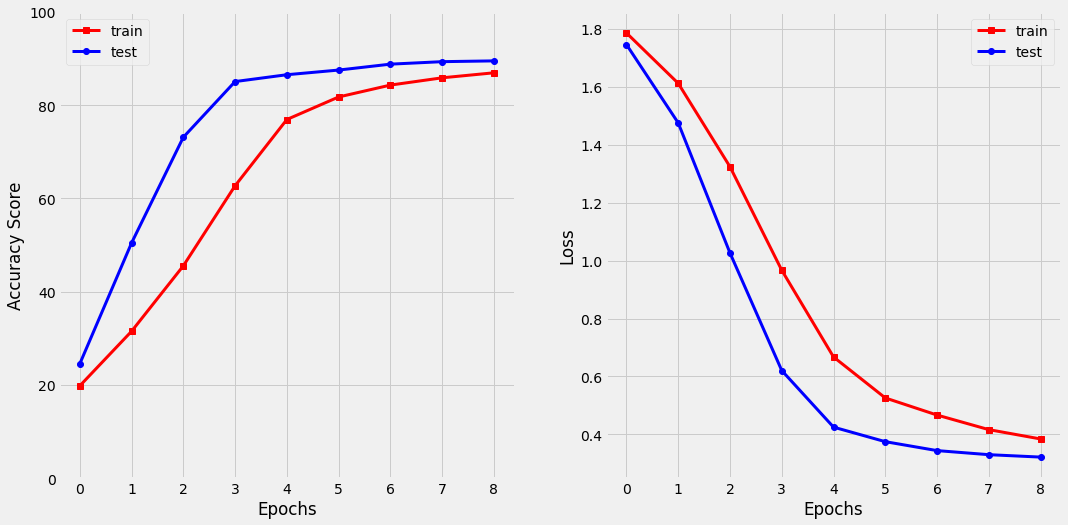

In [ ]:
# plotting results
plot_results(results, name.split(".")[0])

### Saving Model Evaluation File

In [ ]:
# TODO: Load the weights to the model
checkpoint_path = ...

model = MyModel() # change by your model
model.load_weights(checkpoint_path)

In [ ]:
classes_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
# labels to write in the .csv file
labels_csv = ['B', 'F', 'G', 'M','S', 'ST']
labels_csv

['B', 'F', 'G', 'M', 'S', 'ST']

In [ ]:
# Saving the image id and prediction in a .csv file
logname = os.path.join(RESULT_DIR,'sample_submission_first_n.csv')

if not os.path.exists(""):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['id', 'label'])

for img_path in os.listdir("stuff/data/test/test"):
  img_id = img_path
  img_path = os.path.join("stuff/data/test/test", img_path)
  img = image.load_img(img_path, target_size=IMG_SIZE)
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  print(img_batch.shape)

  img_preprocessed = resize_and_rescale(img_batch)

  # TODO: Check what is the result of model predict
  # If the y_pred is the index, which corresponds to an specific class
  # This implementation will not have mistakes.
  # Otherwise, you probably need to add a tf.argmax layer after y_pred
  y_pred = model.predict(img_preprocessed)
  #y_pred = tf.argmax(y_pred)

  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([img_id[0].split(".")[0], labels_csv[y_pred]])

  break

(1, 150, 150, 3)


In [ ]:
results = pd.read_csv(logname, sep =',')
results.head()

,id,label
0,1,B
1,1000,ST
2,10000,M
3,10007,F
4,10010,F
